In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.init as init

import numpy as np
import matplotlib.pyplot as plt
import copy
import random
from ast import Param
import json
import math

from utils.prune import apply_mask
from utils.count_improvement import improvements
from utils.normalize import normalize_weights
from utils.binary_ind import make_to_binary, modify_weights

In [2]:
# Verificar si la GPU está disponible y establecer el dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [4]:
net = Net().to(device)
individuo = Net().to(device)

Cargamos los datos

In [5]:
# Definimos el transform para los datos de MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Cargamos el dataset de MNIST
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

# Definimos los DataLoaders para los conjuntos de entrenamiento y prueba
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False, num_workers=4)

In [6]:
# Definimos la función de pérdida para calcular el error
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [7]:
# train loop
train_loss = []
train_loss_mean = []
test_accuracies = []
n_individuo = 1
accuracy_threshold = 0.4

#Guardo el mejor individuo y la red original que tendrá que ser reestablecida cad epoca
individuo = make_to_binary(individuo)
best_individo_state_dict = individuo.state_dict()
net_state_dict = net.state_dict()

#train loop
while True:
    net.load_state_dict(net_state_dict)
    if n_individuo == 1:
        print(f" --------------------- Individuo {n_individuo} --------------------- ")

        masked_net = apply_mask(net, individuo)
    
        running_loss = 0.0
        # Train for 1 epoch
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            #optimizer.zero_grad()
            outputs = masked_net(inputs)
            loss = criterion(outputs, labels)
            #loss.backward()
            #optimizer.step()
            running_loss += loss.item()
        train_loss.append(running_loss / len(train_loader))

        masked_net.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = masked_net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
        #train_loss_mean.append(np.mean(train_loss))
        test_accuracies.append(accuracy)
        #print(f"Accuracy: {accuracy}, loss mean: {train_loss_mean[-1]}")
        print(f"Accuracy: {accuracy}", f"Loss: {train_loss[-1]}")
        best_loss = train_loss[-1]
        if accuracy > accuracy_threshold:
            break
        n_individuo += 1

        #Variamos el individuo desde el anterior para obtener uno nuevo
        nuevo_individuo = modify_weights(individuo)
        
    else:
        print(f" --------------------- Individuo {n_individuo} --------------------- ")

        masked_net = apply_mask(net, nuevo_individuo)
        
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = masked_net(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
        train_loss.append(running_loss / len(train_loader))

        masked_net.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = masked_net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
        test_accuracies.append(accuracy)
        print(f"Accuracy: {accuracy}", f"Loss: {train_loss[-1]}")
        if accuracy > accuracy_threshold:
            break

        # Verificamos que individuo tiene mejor desempeño
        if train_loss[-1] < best_loss:
            print("Nuevo mejor individuo")
            best_loss = train_loss[-1]
            best_individo_state_dict = nuevo_individuo.state_dict()
        
        # actualizamos el individuo
        individuo.load_state_dict(best_individo_state_dict)

        # Variamos el individuo desde el anterior para obtener uno nuevo
        nuevo_individuo = modify_weights(individuo)

        n_individuo += 1         

 --------------------- Individuo 1 --------------------- 
Accuracy: 0.0916 Loss: 2.3031262705829354
 --------------------- Individuo 2 --------------------- 
Accuracy: 0.111 Loss: 2.3026187206382183
Nuevo mejor individuo
 --------------------- Individuo 3 --------------------- 
Accuracy: 0.0966 Loss: 2.3045410845579624
 --------------------- Individuo 4 --------------------- 
Accuracy: 0.1049 Loss: 2.3014249595751894
Nuevo mejor individuo
 --------------------- Individuo 5 --------------------- 
Accuracy: 0.0596 Loss: 2.303456098031896
 --------------------- Individuo 6 --------------------- 
Accuracy: 0.0891 Loss: 2.302715483504826
 --------------------- Individuo 7 --------------------- 
Accuracy: 0.0983 Loss: 2.3010067540699484
Nuevo mejor individuo
 --------------------- Individuo 8 --------------------- 
Accuracy: 0.075 Loss: 2.3051710583762066
 --------------------- Individuo 9 --------------------- 
Accuracy: 0.0987 Loss: 2.3015920416886875
 --------------------- Individuo 10 --

KeyboardInterrupt: 

In [8]:
print(train_loss)
print(test_accuracies)
print(max(test_accuracies))

[2.3031262705829354, 2.3026187206382183, 2.3045410845579624, 2.3014249595751894, 2.303456098031896, 2.302715483504826, 2.3010067540699484, 2.3051710583762066, 2.3015920416886875, 2.303586264917337, 2.3038982002974064, 2.306235138287168, 2.305221363425509, 2.3059736660548618, 2.30564905229662, 2.3051857167978023, 2.309540401897959, 2.309084403235267, 2.3019971468809572, 2.306934061335094, 2.303216644695827, 2.309658581514094, 2.3087592313030383, 2.3055077870009044, 2.304125882415121, 2.3062998437678126, 2.3055904264897427, 2.3030583866115317, 2.3066489259317233, 2.3060784489869564, 2.307246664185514, 2.30966545955967, 2.3047716198191206, 2.30464879027816, 2.3016787947876365, 2.3056077311542245, 2.3068129934990074, 2.309167851771373, 2.307588434931058, 2.303869070020566, 2.305642445966887, 2.303950663314445, 2.3045395940605764, 2.3051831155443496, 2.303158720164919, 2.3036820512336456, 2.304642719246431, 2.302871348252937, 2.302573237083614, 2.303080553439126, 2.304386936525292, 2.304298

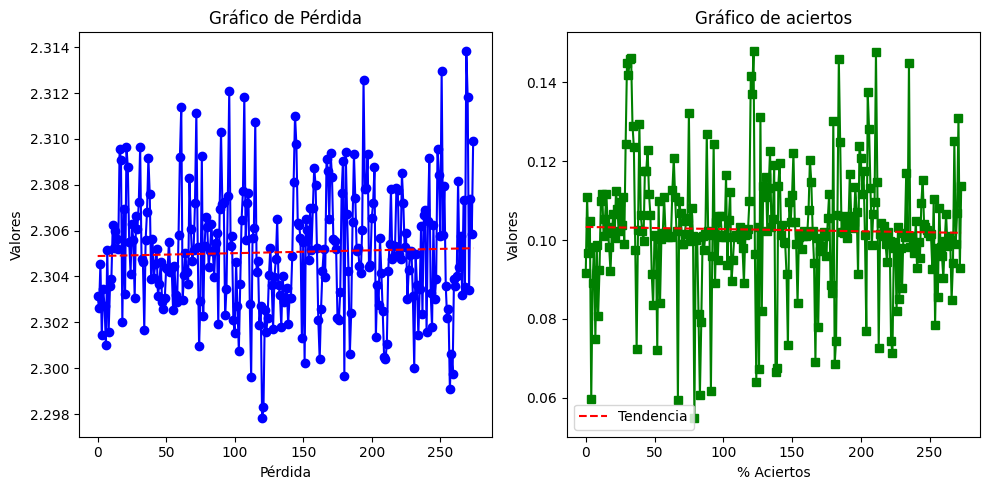

In [9]:
# Creamos la figura y definimos dos subgráficos (1 fila, 2 columnas)
plt.figure(figsize=(10, 5))

# Primer gráfico en la posición 1 (izquierda)
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.plot(train_loss, color='blue', marker='o')
plt.title("Gráfico de Pérdida")
plt.xlabel("Pérdida")
plt.ylabel("Valores")

# Calcular la regresión lineal para train_loss
epochs = np.arange(len(train_loss))
m, b = np.polyfit(epochs, train_loss, 1)
plt.plot(epochs, m*epochs + b, color='red', linestyle='--', label='Tendencia')


# Segundo gráfico en la posición 2 (derecha)
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
plt.plot(test_accuracies, color='green', marker='s')
plt.title("Gráfico de aciertos")
plt.xlabel("% Aciertos")
plt.ylabel("Valores")

# Calcular la regresión lineal para test_accuracies
epochs_test = np.arange(len(test_accuracies))
m, b = np.polyfit(epochs_test, test_accuracies, 1)
plt.plot(epochs_test, m*epochs_test + b, color='red', linestyle='--', label='Tendencia')

# Mostramos los gráficos
plt.tight_layout()  # Ajustamos para que no se solapen los gráficos
plt.legend()
plt.show()